In [1]:
import sys
sys.path.insert(1, '/home/samuel/EFARS/')

import torch
from glob import glob
import random

from models.sem_gcn import SemGCN
from models.mlp import MLP
from data.human36m import Human36M2DTo3DDataset, Human36MMetadata, image_coordinates
from utils.misc import seed_everything
from utils.graph import adj_mx_from_edges
from utils.visualization import show_pos2d_with_projected_pos3d, show_pos3d

/home/samuel/anaconda3/envs/pose/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed_everything(1120)

root_path = '/home/samuel/h36m'
img_path = root_path + '/imgs'
pos2d_path = root_path + '/pos2d'
pos3d_path = root_path + '/pos3d'

img_fns = glob(img_path+'/*.jpg')
random.shuffle(img_fns)
test_fns = img_fns[60000:70000]

In [3]:
#test_dataset = Human36M2DTo3DDataset(test_fns, pos2d_path, pos3d_path, transforms=do_2d_to_3d_transforms)
test_dataset = Human36M2DTo3DDataset(test_fns, pos2d_path, pos3d_path)

In [4]:
import json
cps = json.load(open(Human36MMetadata.camera_parameters_path, 'r'))

In [5]:
from collections import OrderedDict
#net = MLP(num_joint=17, pretrained=True)
net = SemGCN(adj=adj_mx_from_edges(Human36MMetadata.num_joints, Human36MMetadata.skeleton_edges, sparse=False), hid_dim=128)
checkpoint = torch.load('/home/samuel/EFARS/estimator/checkpoints/SemGCN-20-1e-3/best-checkpoint-000epoch.bin', map_location=torch.device('cpu'))
state_dict = checkpoint['model_state_dict']
new_sd = OrderedDict()
for k, v in state_dict.items():
    new_sd[k[7:]] = v
net.load_state_dict(new_sd)
net.load_state_dict(state_dict)
net.eval()

TemporalModelOptimized1f(
  (drop): Dropout(p=0.25, inplace=False)
  (relu): ReLU(inplace=True)
  (expand_bn): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (shrink): Conv1d(1024, 51, kernel_size=(1,), stride=(1,))
  (expand_conv): Conv1d(34, 1024, kernel_size=(1,), stride=(1,), bias=False)
  (layers_conv): ModuleList(
    (0): Conv1d(1024, 1024, kernel_size=(1,), stride=(1,), bias=False)
    (1): Conv1d(1024, 1024, kernel_size=(1,), stride=(1,), bias=False)
    (2): Conv1d(1024, 1024, kernel_size=(1,), stride=(1,), bias=False)
    (3): Conv1d(1024, 1024, kernel_size=(1,), stride=(1,), bias=False)
    (4): Conv1d(1024, 1024, kernel_size=(1,), stride=(1,), bias=False)
    (5): Conv1d(1024, 1024, kernel_size=(1,), stride=(1,), bias=False)
    (6): Conv1d(1024, 1024, kernel_size=(1,), stride=(1,), bias=False)
    (7): Conv1d(1024, 1024, kernel_size=(1,), stride=(1,), bias=False)
  )
  (layers_bn): ModuleList(
    (0): BatchNorm1d(1024, eps=1e-05, mome

In [7]:
pos2d, pos3d, P, R, t = test_dataset[888]
pos2d = pos2d.unsqueeze(0)
pos3d = pos3d.unsqueeze(0)
pred = net(pos2d.float())

pred = pred.squeeze().detach()
pos2d = pos2d.squeeze().detach()
pos3d = pos3d.squeeze().detach()
#pred = (pred * 1000) @ R

In [8]:
pos2d = torch.from_numpy(image_coordinates(pos2d.numpy(), 1000, 1000))

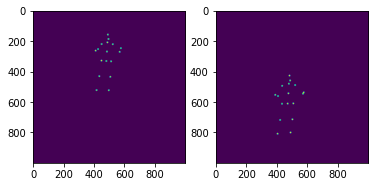

In [9]:
show_pos2d_with_projected_pos3d(pos2d, pred, (1000, 1000), P)

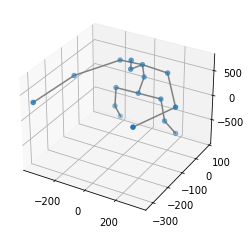

In [10]:
show_pos3d(pos3d*1000, Human36MMetadata.skeleton_edges)

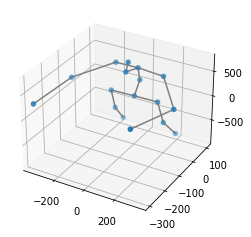

In [11]:
show_pos3d(pred, Human36MMetadata.skeleton_edges)